In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
idle = pd.read_csv('data/idle.csv', index_col=0)
idle0 = idle.iloc[0]['Idle W']
idle['Idle W'] -= idle0
idle

,Idle W
#Busy,
0,0.000000
1,10.283708
2,12.248773
3,14.476905
4,16.816932
5,19.217805
6,21.921194
7,24.101344
8,26.641901


In [97]:
names = ['#Busy', '#Threads', 'Runtime (s)', 'Usertime (s)', 'Energy (J)']
df = pd.read_csv('data/matmul_cn126_800.csv', names=names, usecols=[0, 1, 3, 4, 5])

df['Energy (J) w/ idle'] = df['Energy (J)']

user_max = df['Runtime (s)'] * df['#Threads']
user_pct = df['Usertime (s)'] / user_max
user_pct = user_pct.clip(upper=1.0)
df['Usertime (s)'] /= df['#Threads']
df['%User'] = user_pct

# TODO: Somehow subtract artificial BG energy
df['Energy (J)'] -= df['Runtime (s)'] * idle0
idle_w = df.apply(lambda row: idle.iloc[int(row['#Busy'])]['Idle W'], axis=1)
df['Energy (J)'] -= (1.0 - df['%User']) * df['Runtime (s)'] * idle_w

df['Energy (J) User'] = df['Energy (J)'] * df['%User']

df

,#Busy,#Threads,Runtime (s),Usertime (s),Energy (J),Energy (J) w/ idle,%User,Energy (J) User
0,0,1,0.726692,0.726601,8.576053,11.364140,0.999874,8.574976
1,0,2,0.375857,0.375893,6.227455,7.669499,1.000000,6.227455
2,0,3,0.251032,0.251610,5.207101,6.170232,1.000000,5.207101
3,0,4,0.188508,0.188084,4.704425,5.427669,0.997751,4.693843
4,0,5,0.150663,0.151704,4.494032,5.072076,1.000000,4.494032
5,0,6,0.125803,0.124441,4.220255,4.702922,0.989174,4.174566
6,0,7,0.108202,0.107991,4.119012,4.534149,0.998051,4.110983
7,0,8,0.094704,0.095834,4.017584,4.380932,1.000000,4.017584
8,0,9,0.137256,0.139876,5.441722,5.968328,1.000000,5.441722
9,0,10,0.124466,0.124032,5.029285,5.506822,0.996512,5.011744


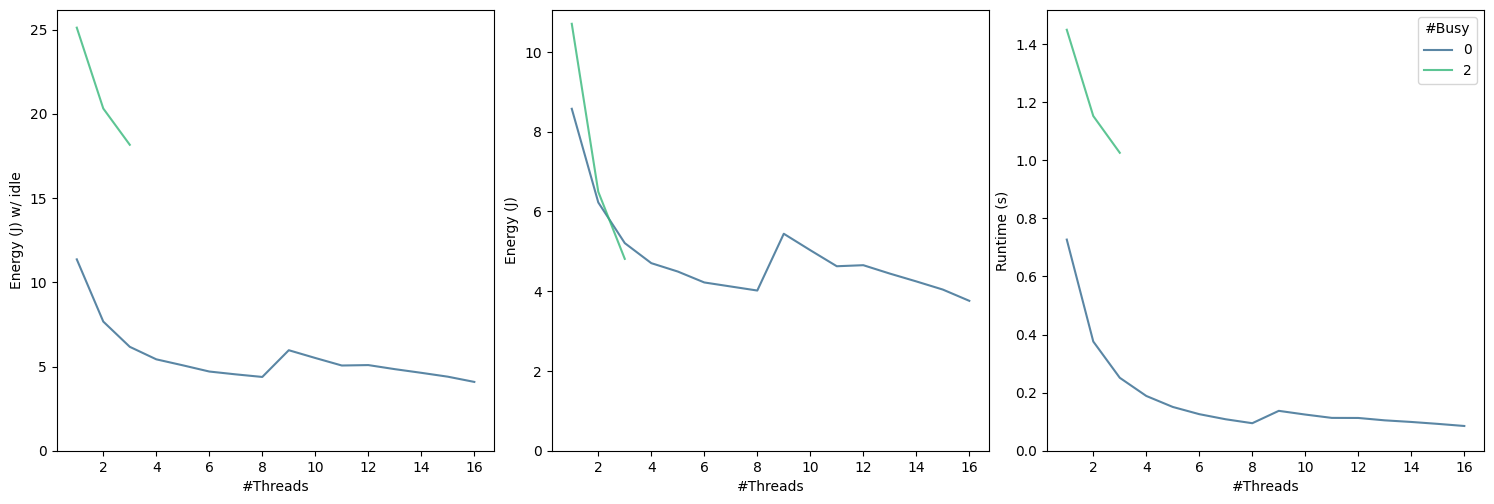

In [98]:
fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()

hue = df['#Busy'].astype('category')

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J) w/ idle', hue=hue, palette='viridis', alpha=0.8, ax=ax_idle, legend=False)
ax_idle.set_ylim((0, None))

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J)', hue=hue, palette='viridis', alpha=0.8, ax=ax_energy, legend=False)
ax_energy.set_ylim((0, None))

# Runtime
sns.lineplot(df, x='#Threads', y='Runtime (s)', hue=hue, palette='viridis', alpha=0.8, ax=ax_runtime)
ax_runtime.set_ylim((0, None))

plt.show()

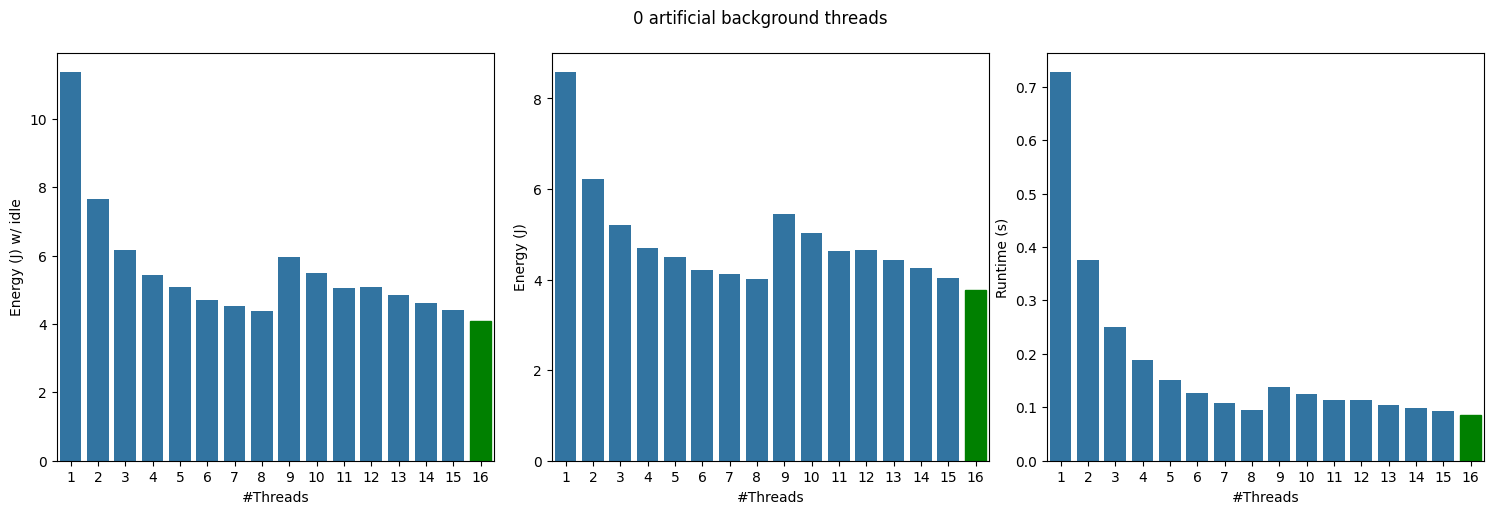

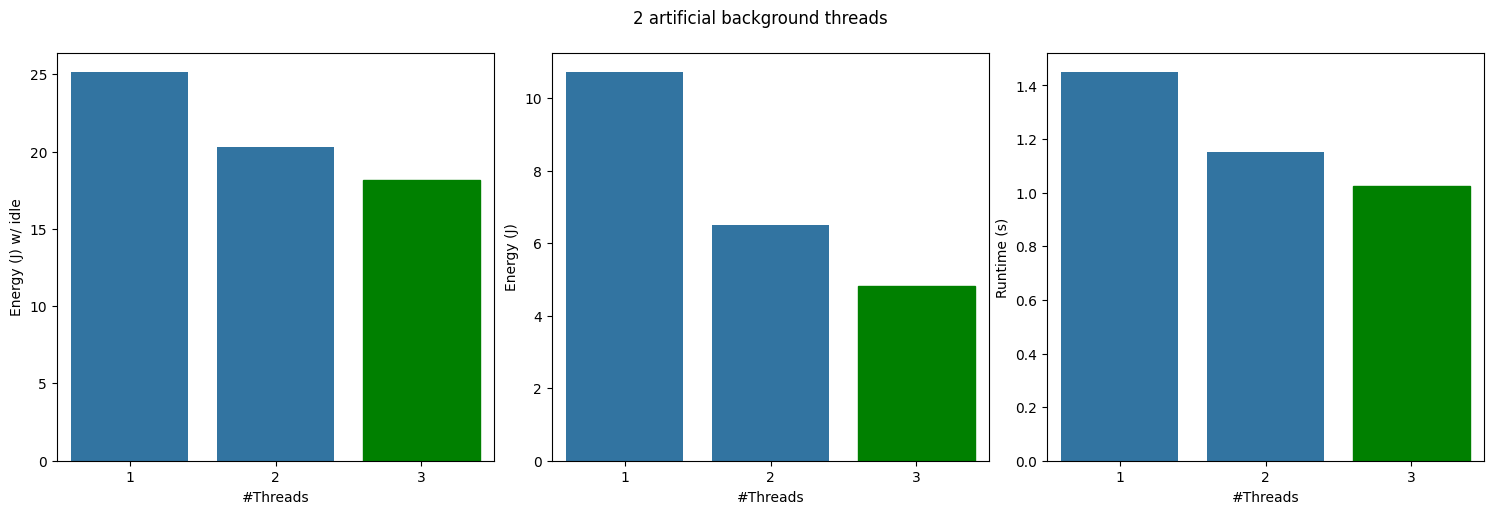

In [99]:
for busy in df['#Busy'].unique():
    dfx = df[df['#Busy'] == busy]
    
    fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'{busy} artificial background threads')
    fig.tight_layout()

    sns.barplot(dfx, x='#Threads', y='Energy (J) w/ idle', ax=ax_idle)
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_energy)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_runtime)
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_idle, 'Energy (J) w/ idle')
    color_best(ax_energy, 'Energy (J)')
    color_best(ax_runtime, 'Runtime (s)')
    
    plt.show()

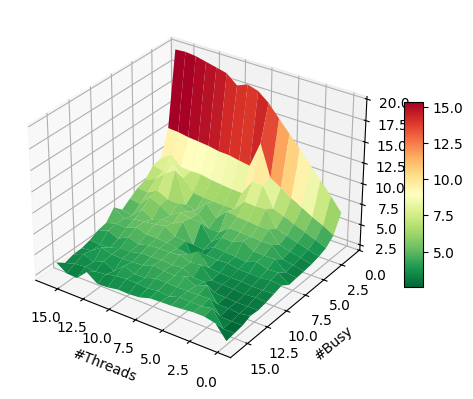

In [87]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

y1 = np.linspace(df['#Threads'].min(), df['#Threads'].max(), len(df['#Threads'].unique()))
x1 = np.linspace(df['#Busy'].min(), df['#Busy'].max(), len(df['#Busy'].unique()))

x2, y2 = np.meshgrid(x1, y1)

z2 = griddata((df['#Busy'], df['#Threads']), df['Energy (J)'], (x2, y2))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x2, y2, z2, cmap='RdYlGn_r')

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('#Threads')
ax.set_ylabel('#Busy')

ax.view_init(30, 125)

plt.show()

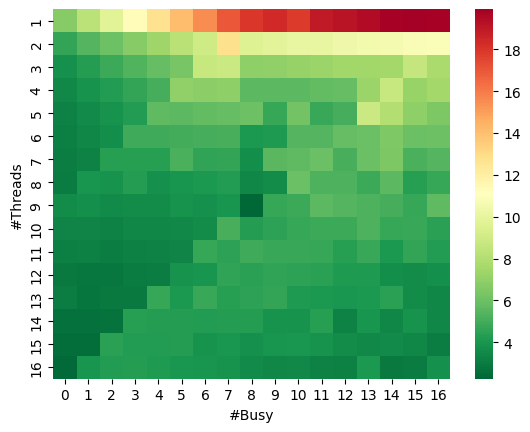

In [88]:
hm = df.pivot(index='#Threads', columns='#Busy', values='Energy (J)')
ax = sns.heatmap(hm, cmap='RdYlGn_r')
#ax.invert_yaxis()
plt.show()